In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Importing necessary libraries
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelBinarizer

In [ ]:
# Function to load images from a folder
def load_images_from_folder(folder):
    images = []
    labels = []
    for label in os.listdir(folder):
        for img_file in os.listdir(os.path.join(folder, label)):
            img_path = os.path.join(folder, label, img_file)
            img = tf.keras.preprocessing.image.load_img(img_path, target_size=(128, 128))
            img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0  # Normalize to [0, 1]
            images.append(img_array)
            labels.append(label)
    return np.array(images), np.array(labels)

# Load images
train_images, train_labels = load_images_from_folder('/content/drive/MyDrive/DATASET/dataset/train')
val_images, val_labels = load_images_from_folder('/content/drive/MyDrive/DATASET/dataset/valid')
test_images, test_labels = load_images_from_folder('/content/drive/MyDrive/DATASET/dataset/test')

# Shuffle the dataset
train_images, train_labels = shuffle(train_images, train_labels, random_state=42)

# Encode labels to numeric values
lb = LabelBinarizer()
train_labels_encoded = lb.fit_transform(train_labels).flatten()  # Flatten to 1D array
val_labels_encoded = lb.transform(val_labels).flatten()
test_labels_encoded = lb.transform(test_labels).flatten()

# Data augmentation with stronger augmentations
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [ ]:
# Function to create CNN model with additional layers and regularization
def create_cnn_model():
    model = Sequential()
    model.add(Input(shape=(128, 128, 3)))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))

    model.add(Flatten())
    model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    return model

# Initialize early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, verbose=1)

# Create and compile the CNN model
cnn_model = create_cnn_model()
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Fit the model using data augmentation
cnn_model.fit(datagen.flow(train_images, train_labels_encoded, batch_size=32),
              epochs=50,
              validation_data=(val_images, val_labels_encoded),
              callbacks=[early_stopping, lr_reduction])

# Evaluate CNN model
cnn_loss, cnn_accuracy = cnn_model.evaluate(test_images, test_labels_encoded)
print(f'CNN Test Accuracy: {cnn_accuracy * 100:.2f}%')


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


81/81 ━━━━━━━━━━━━━━━━━━━━ 162s 2s/step - accuracy: 0.5532 - loss: 4.5281 - val_accuracy: 0.5000 - val_loss: 10.3393 - learning_rate: 0.0010
Epoch 2/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 200s 2s/step - accuracy: 0.6235 - loss: 1.3823 - val_accuracy: 0.5000 - val_loss: 9.7010 - learning_rate: 0.0010
Epoch 3/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 204s 2s/step - accuracy: 0.6439 - loss: 1.2778 - val_accuracy: 0.5000 - val_loss: 5.4282 - learning_rate: 0.0010
Epoch 4/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 200s 2s/step - accuracy: 0.6772 - loss: 1.1869 - val_accuracy: 0.5000 - val_loss: 1.9105 - learning_rate: 0.0010
Epoch 5/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 202s 2s/step - accuracy: 0.6693 - loss: 1.1236 - val_accuracy: 0.5000 - val_loss: 2.7577 - learning_rate: 0.0010
Epoch 6/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 202s 2s/step - accuracy: 0.6721 - loss: 1.0511 - val_accuracy: 0.5500 - val_loss: 1.7835 - learning_rate: 0.0010
Epoch 7/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 156s 2s/step - accuracy: 0.6526 - loss: 1.0175 - val_accuracy: 0.6

In [ ]:
# Predict with CNN
cnn_predictions = (cnn_model.predict(test_images) > 0.5).astype(int)

10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 717ms/step


In [ ]:
# SVM model
svm_model = SVC(kernel='linear', probability=True)
svm_model.fit(train_images.reshape(len(train_images), -1), train_labels)
svm_predictions = svm_model.predict(test_images.reshape(len(test_images), -1))
svm_test_accuracy = accuracy_score(test_labels, svm_predictions)
print(f"SVM Test Accuracy: {svm_test_accuracy * 100:.2f}%")

# Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(train_images.reshape(len(train_images), -1), train_labels)
rf_predictions = rf_model.predict(test_images.reshape(len(test_images), -1))
rf_test_accuracy = accuracy_score(test_labels, rf_predictions)
print(f"Random Forest Test Accuracy: {rf_test_accuracy * 100:.2f}%")

SVM Test Accuracy: 67.33%
Random Forest Test Accuracy: 75.67%


10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 387ms/step

CNN Model Evaluation:
              precision    recall  f1-score   support

           0       0.73      0.84      0.78       150
           1       0.81      0.69      0.75       150

    accuracy                           0.77       300
   macro avg       0.77      0.77      0.77       300
weighted avg       0.77      0.77      0.77       300



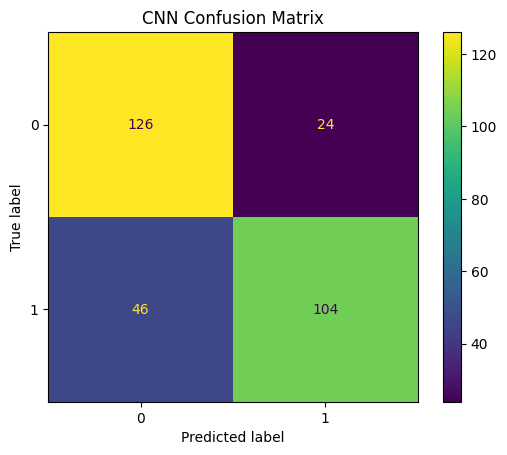

10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 425ms/step
CNN ROC AUC Score: 0.84


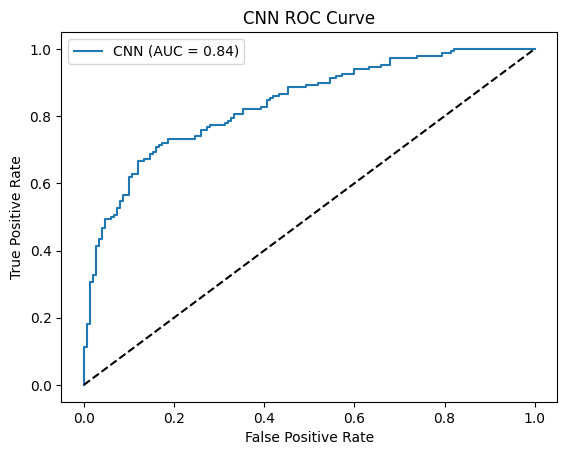


SVM Model Evaluation:
              precision    recall  f1-score   support

           0       0.69      0.62      0.65       150
           1       0.66      0.73      0.69       150

    accuracy                           0.67       300
   macro avg       0.68      0.67      0.67       300
weighted avg       0.68      0.67      0.67       300



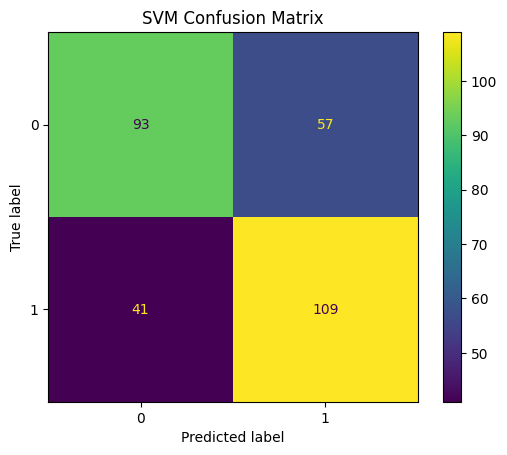

SVM ROC AUC Score: 0.75


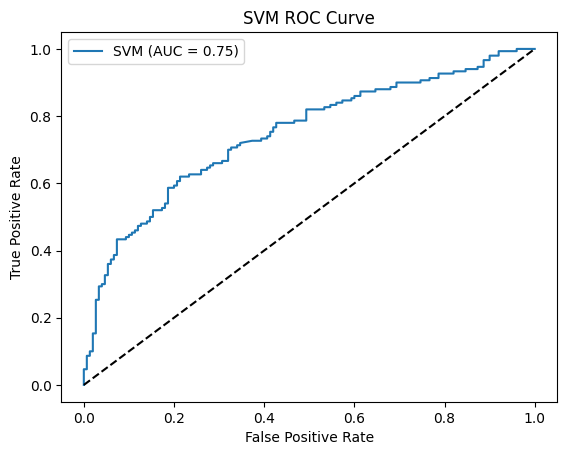


Random Forest Model Evaluation:
              precision    recall  f1-score   support

           0       0.75      0.78      0.76       150
           1       0.77      0.73      0.75       150

    accuracy                           0.76       300
   macro avg       0.76      0.76      0.76       300
weighted avg       0.76      0.76      0.76       300



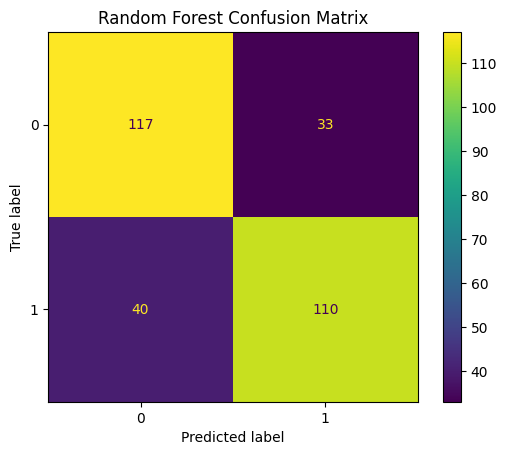

Random Forest ROC AUC Score: 0.83


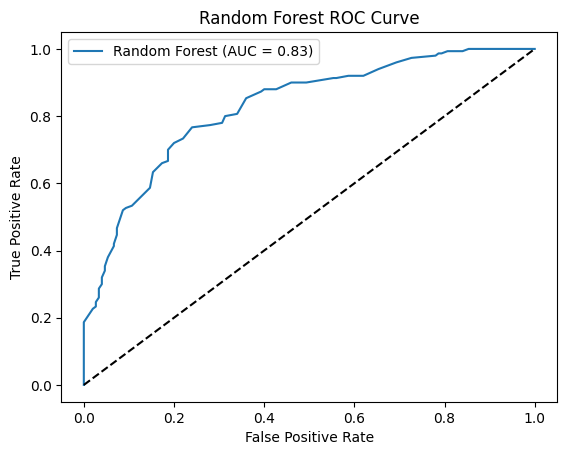

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Assuming test_labels are in string format ('autistic', 'non_autistic')
# Convert the string labels to numeric labels
label_encoder = LabelEncoder()
label_encoder.fit(['non_autistic', 'autistic'])  # Fit the encoder with class labels
test_labels_numeric = label_encoder.transform(test_labels)

# Make predictions using the CNN model
cnn_predictions_prob = cnn_model.predict(test_images)
cnn_predictions_numeric = (cnn_predictions_prob > 0.5).astype("int32").flatten()

# Calculate metrics for CNN
calculate_metrics(test_labels_numeric, cnn_predictions_numeric, 'CNN')

# Convert SVM and Random Forest predictions to numeric labels if they are in string format
# Assuming svm_predictions and rf_predictions are in string format
svm_predictions_numeric = label_encoder.transform(svm_predictions)
rf_predictions_numeric = label_encoder.transform(rf_predictions)

# Calculate metrics for SVM and Random Forest
calculate_metrics(test_labels_numeric, svm_predictions_numeric, 'SVM')
calculate_metrics(test_labels_numeric, rf_predictions_numeric, 'Random Forest')


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 283ms/step


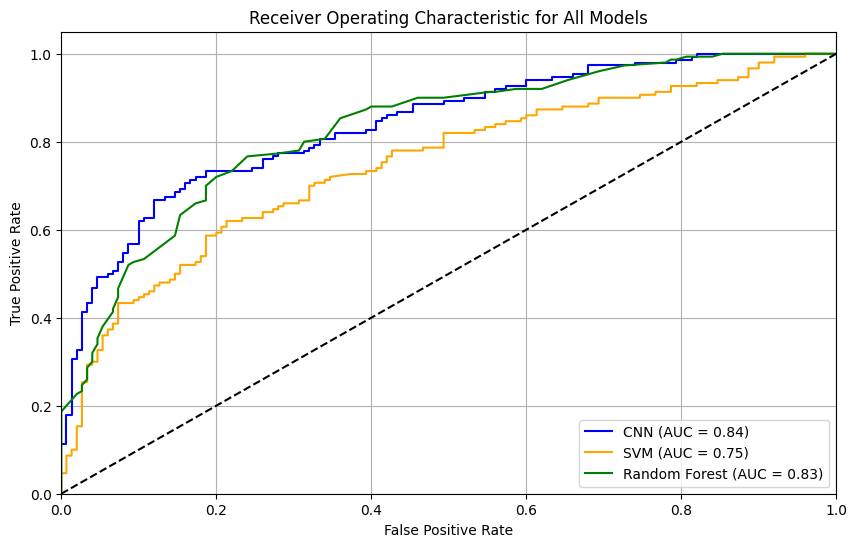

In [ ]:
# Assuming test_images is of shape (num_samples, height, width, channels)
num_samples = test_images.shape[0]
test_images_flattened = test_images.reshape(num_samples, -1)  # Flatten each image

# For SVM and Random Forest, use the predictions (ensure they are probabilities)
svm_scores = svm_model.predict_proba(test_images_flattened)[:, 1]  # Get probabilities for the positive class
rf_scores = rf_model.predict_proba(test_images_flattened)[:, 1]    # Get probabilities for the positive class

# Continue with plotting ROC curves as before
plt.figure(figsize=(10, 6))

# For CNN, use predicted probabilities
cnn_scores = cnn_model.predict(test_images).ravel()
plot_roc_curve(y_true_binary, cnn_scores, 'CNN', color='blue')
plot_roc_curve(y_true_binary, svm_scores, 'SVM', color='orange')
plot_roc_curve(y_true_binary, rf_scores, 'Random Forest', color='green')

# Final plot settings
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for All Models')
plt.legend(loc="lower right")
plt.grid()
plt.show()
